In [23]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import datetime
import cv2 
from skimage.transform import resize



In [2]:
data_dir = "malaria_hematie_dataset"

In [4]:

image_size = (64, 64,3)
total_samples = 13780
samples_size = total_samples

images_array = []
labels = []
current_index = 0

for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    for img_name in tqdm(os.listdir(label_path)):
        img_path = os.path.join(label_path, img_name)
        images_array.append(resize(cv2.imread(img_path), image_size, anti_aliasing=True))
        labels.append(label)
        current_index += 1
labels_df = pd.DataFrame(labels, columns=['label'])


100%|██████████| 13779/13779 [03:11<00:00, 72.04it/s]


In [6]:
print("First few entries in labels DataFrame:")
print(labels_df.tail())

First few entries in labels DataFrame:
            label
27553  uninfected
27554  uninfected
27555  uninfected
27556  uninfected
27557  uninfected


In [7]:
len(images_array)
print(len(images_array))
print(len(labels))

27558
27558


In [8]:
images_array[27557].shape

(64, 64, 3)

In [9]:
# import numpy as np

# def min_max_normalize(image):
#     # return (image - np.min(image)) / (np.max(image) - np.min(image))
#     return image.astype(np.float32) / 255.0

# normalized_images = [min_max_normalize(img) for img in images_array]


In [10]:
encoder = LabelEncoder()
labels = np.array(labels)
encoded_labels = encoder.fit_transform(labels)

In [11]:
images_n_array =images_array #numpy.expand_dims(images_array, axis=-1)

In [12]:
print(len(images_n_array))
print(len(encoded_labels))

27558
27558


In [13]:

images_n_array = np.array(images_n_array)
encoded_labels = np.array(encoded_labels)

split_ratio = 0.85
split_index = int(len(images_n_array) * split_ratio)

permutation = np.random.permutation(len(images_n_array))

train_images_array = images_n_array[permutation[:split_index]]
test_images_array = images_n_array[permutation[split_index:]]
train_labels = encoded_labels[permutation[:split_index]]
test_labels = encoded_labels[permutation[split_index:]]

print(f"Train images shape: {train_images_array.shape}")
print(f"Test images shape: {test_images_array.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")


Train images shape: (23424, 64, 64, 3)
Test images shape: (4134, 64, 64, 3)
Train labels shape: (23424,)
Test labels shape: (4134,)


In [14]:
len(train_labels)

23424

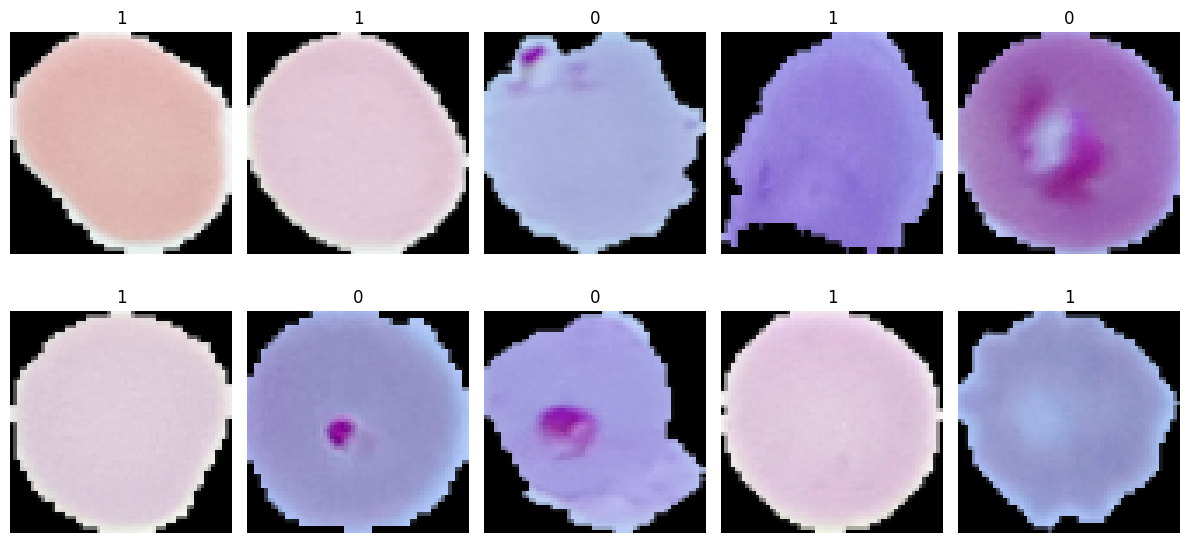

In [24]:
def imshow(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.figure(figsize=(12, 6))
num_images = len(train_images_array) // 2
for i in range(num_images - 5, num_images + 5):
    plt.subplot(2, 5, i - num_images + 6)
    image = np.squeeze(train_images_array[i])
    label = train_labels[i]
    imshow(image, label)

plt.tight_layout()
plt.show()

In [25]:
data_augmentation_generator = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.2,
    validation_split=0.15,
)

In [18]:
batch_size = 20
image_train_generator = data_augmentation_generator.flow(train_images_array, train_labels, batch_size=batch_size, subset="training", seed=42, shuffle=True)
image_val_generator = data_augmentation_generator.flow(train_images_array, train_labels, batch_size=batch_size, subset="validation", seed=42, shuffle=True)

In [19]:
image_train_generator

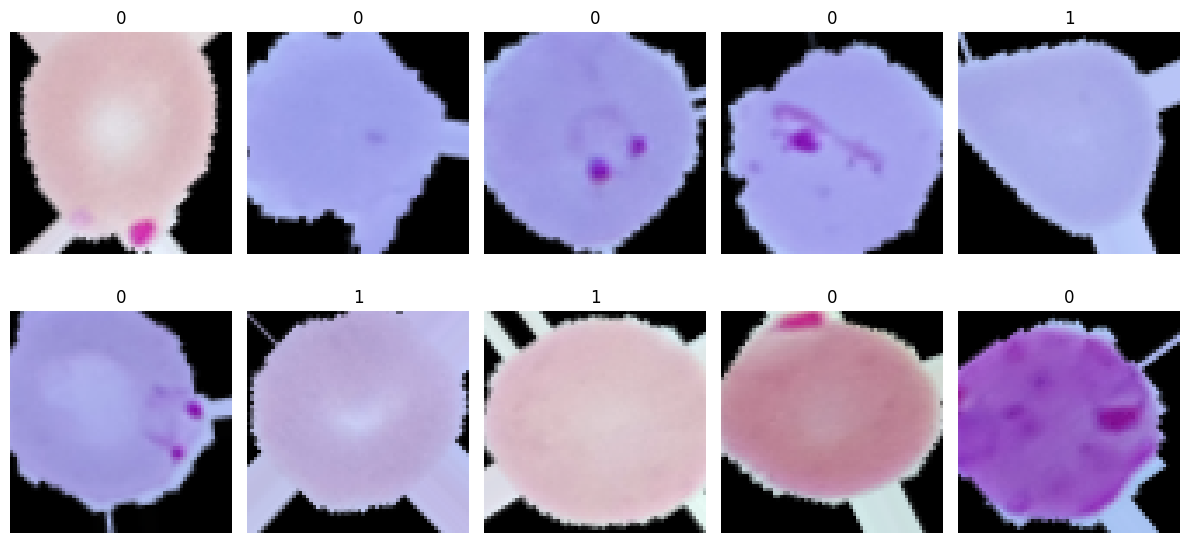

In [26]:
images_batch, labels_batch = next(image_train_generator)

# Plot images from the batch
plt.figure(figsize=(12, 6))
num_images = len(images_batch) // 2
for i in range(num_images - 5, num_images + 5):
    plt.subplot(2, 5, i - num_images + 6)
    image = np.squeeze(images_batch[i])
    label = labels_batch[i]
    imshow(image, label)

plt.tight_layout()
plt.show()

In [27]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=int(1e-5), verbose=1)

In [30]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

callbacks = [
    EarlyStopping(patience=3, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=2, monitor='val_loss')
]

# Compilation et entraînement des modèles
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [48]:
np.save('train_images_array.npy', images_array)


In [31]:
history = cnn_model.fit(image_train_generator, epochs=50,
                        validation_data=image_val_generator,
                        callbacks=[early_stopping, learning_rate_decay,tensorboard_callback])


Epoch 1/50


c:\Users\a3zak\Desktop\bader_project\malaria\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 73s 72ms/step - accuracy: 0.6373 - loss: 0.6448 - val_accuracy: 0.8844 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 2/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.8946 - loss: 0.2880 - val_accuracy: 0.9280 - val_loss: 0.1975 - learning_rate: 0.0010
Epoch 3/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.9231 - loss: 0.2268 - val_accuracy: 0.9397 - val_loss: 0.1931 - learning_rate: 0.0010
Epoch 4/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 0.9346 - loss: 0.2115 - val_accuracy: 0.9439 - val_loss: 0.1746 - learning_rate: 0.0010
Epoch 5/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.9359 - loss: 0.1989 - val_accuracy: 0.9522 - val_loss: 0.1630 - learning_rate: 0.0010
Epoch 6/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - accuracy: 0.9408 - loss: 0.1855 - val_accuracy: 0.9431 - val_loss: 0.1783 - learning_rate: 0.0010
Epoch 7/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.9422 - loss: 0.1806

In [32]:

def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name}: Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name}: Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

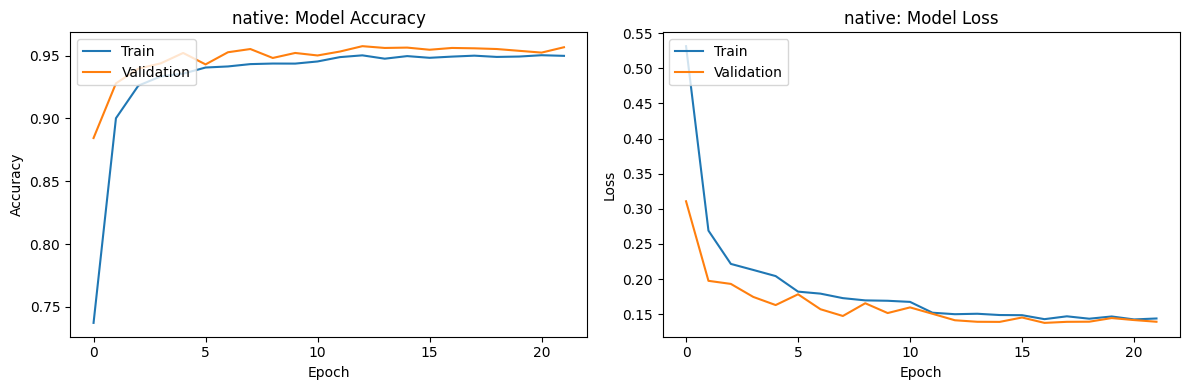

In [35]:
plot_history(history,"native")

In [37]:
cnn_model.save_weights('malaria_classifier.weights.h5')

In [38]:
y_pred = cnn_model.predict(test_images_array)

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [39]:

confusion_matrix = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))

print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[1995  104]
 [  50 1985]]


In [40]:

accuracy = accuracy_score(test_labels, np.argmax(y_pred, axis=1))
precision = precision_score(test_labels, np.argmax(y_pred, axis=1))
recall = recall_score(test_labels, np.argmax(y_pred, axis=1))
f1 = f1_score(test_labels, np.argmax(y_pred, axis=1))

print("Performance Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Performance Metrics:
Accuracy: 0.963
Precision: 0.950
Recall: 0.975
F1-score: 0.963


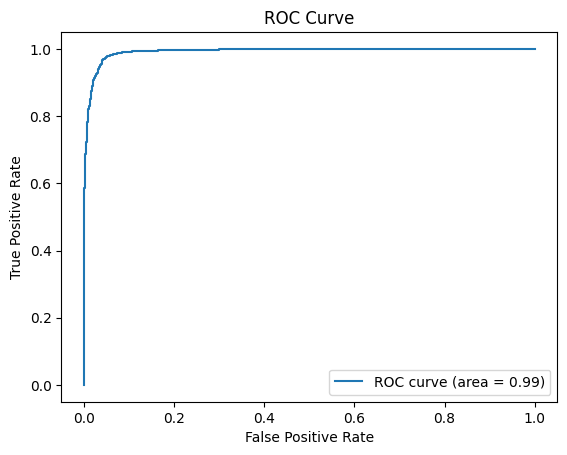

In [41]:

fpr, tpr, thresholds = roc_curve(test_labels, y_pred[:, 1])
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def define_model_vgg16(image_shape=(64, 64, 3), num_classes=2):

  base_model = VGG16(weights="imagenet", include_top=False, input_shape=image_shape)

  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.output
  x = Flatten()(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.5)(x)
  predictions = Dense(num_classes, activation="softmax")(x)

  model = Model(inputs=base_model.input, outputs=predictions)

  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"],
  )

  return model

def define_model_resnet50(image_shape=(64, 64, 3), num_classes=2):
  base_model = ResNet50(weights="imagenet", include_top=False, input_shape=image_shape)

  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.output
  x = Flatten()(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(0.5)(x)
  predictions = Dense(num_classes, activation="softmax")(x)

  model = Model(inputs=base_model.input, outputs=predictions)

  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"],
  )

  return model


In [59]:
vgg16_model = define_model_vgg16()
resnet50_model = define_model_resnet50()


In [49]:
history_vgg = vgg16_model.fit(image_train_generator, epochs=50, validation_data=image_val_generator, callbacks=[early_stopping, learning_rate_decay])

Epoch 1/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 271s 270ms/step - accuracy: 0.8050 - loss: 0.4147 - val_accuracy: 0.8648 - val_loss: 0.3137 - learning_rate: 0.0010
Epoch 2/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 274s 275ms/step - accuracy: 0.8770 - loss: 0.2961 - val_accuracy: 0.9009 - val_loss: 0.2392 - learning_rate: 0.0010
Epoch 3/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 270s 271ms/step - accuracy: 0.8848 - loss: 0.2852 - val_accuracy: 0.9061 - val_loss: 0.2355 - learning_rate: 0.0010
Epoch 4/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 265s 266ms/step - accuracy: 0.8931 - loss: 0.2668 - val_accuracy: 0.9174 - val_loss: 0.2211 - learning_rate: 0.0010
Epoch 5/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 265s 266ms/step - accuracy: 0.8922 - loss: 0.2730 - val_accuracy: 0.9172 - val_loss: 0.2230 - learning_rate: 0.0010
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [51]:
test_generator = data_augmentation_generator.flow(test_images_array, test_labels, batch_size=batch_size, subset="validation", seed=42, shuffle=True)

In [52]:
vgg16_loss, vgg16_acc = vgg16_model.evaluate(image_val_generator)
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(test_generator)

176/176 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.8614 - loss: 0.3189


c:\Users\a3zak\Desktop\bader_project\malaria\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.8491 - loss: 0.3366


In [60]:
history_resnet = resnet50_model.fit(image_train_generator, epochs=50, validation_data=image_val_generator, callbacks=[early_stopping, learning_rate_decay])

Epoch 1/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 678s 674ms/step - accuracy: 0.5373 - loss: 0.7079 - val_accuracy: 0.6169 - val_loss: 0.6651 - learning_rate: 0.0010
Epoch 2/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 649s 652ms/step - accuracy: 0.5825 - loss: 0.6719 - val_accuracy: 0.6299 - val_loss: 0.6539 - learning_rate: 0.0010
Epoch 3/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 648s 651ms/step - accuracy: 0.5802 - loss: 0.6682 - val_accuracy: 0.6334 - val_loss: 0.6477 - learning_rate: 0.0010
Epoch 4/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 646s 649ms/step - accuracy: 0.6039 - loss: 0.6619 - val_accuracy: 0.6197 - val_loss: 0.6524 - learning_rate: 0.0010
Epoch 5/50
996/996 ━━━━━━━━━━━━━━━━━━━━ 648s 650ms/step - accuracy: 0.6118 - loss: 0.6557 - val_accuracy: 0.6547 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [61]:
resnet50_loss, resnet50_acc = resnet50_model.evaluate(image_val_generator)
resnet50_test_loss, resnet50_test_acc = resnet50_model.evaluate(test_generator)

176/176 ━━━━━━━━━━━━━━━━━━━━ 92s 524ms/step - accuracy: 0.6115 - loss: 0.6667
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 537ms/step - accuracy: 0.5958 - loss: 0.6727


130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 290ms/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 82s 628ms/step
VGG16 Test Accuracy: 0.85161292552948
ResNet50 Test Accuracy: 0.5822580456733704


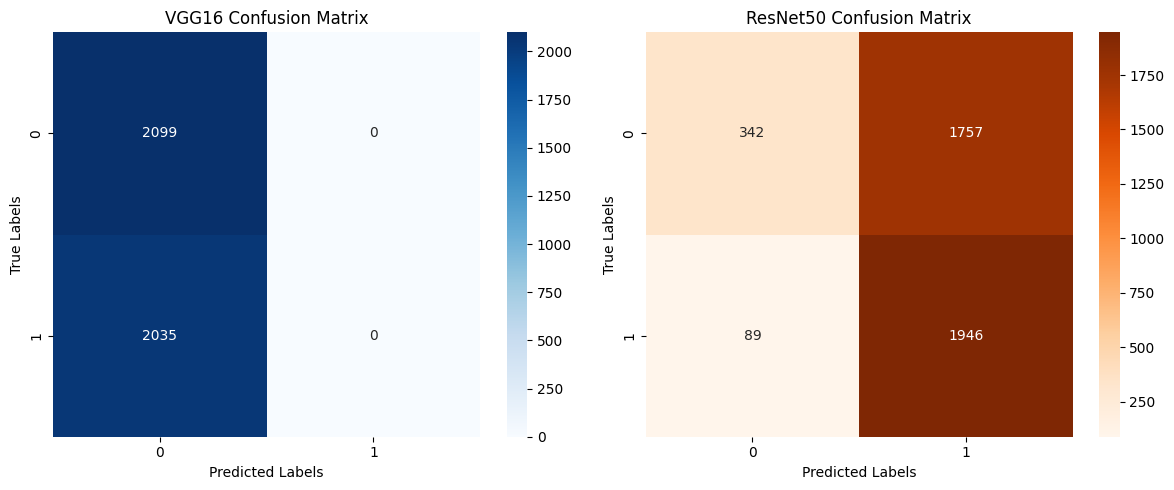

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

vgg16_pred = vgg16_model.predict(test_images_array)
resnet50_pred = resnet50_model.predict(test_images_array)

vgg16_pred_labels = np.argmax(vgg16_pred, axis=1)
resnet50_pred_labels = np.argmax(resnet50_pred, axis=1)

conf_matrix_vgg16 = confusion_matrix(test_labels, vgg16_pred_labels)
conf_matrix_resnet50 = confusion_matrix(test_labels, resnet50_pred_labels)

print("VGG16 Test Accuracy:", vgg16_test_acc)
print("ResNet50 Test Accuracy:", resnet50_test_acc)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_matrix_vgg16, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('VGG16 Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(conf_matrix_resnet50, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('ResNet50 Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


In [67]:
def print_performance_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, np.argmax(y_pred, axis=1))
    precision = precision_score(y_true, np.argmax(y_pred, axis=1))
    recall = recall_score(y_true, np.argmax(y_pred, axis=1))
    f1 = f1_score(y_true, np.argmax(y_pred, axis=1))

    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")

print_performance_metrics(test_labels, vgg16_pred, "VGG16")
print_performance_metrics(test_labels, resnet50_pred, "ResNet50")

Performance Metrics for VGG16:
Accuracy: 0.508
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Performance Metrics for ResNet50:
Accuracy: 0.553
Precision: 0.526
Recall: 0.956
F1-score: 0.678


c:\Users\a3zak\Desktop\bader_project\malaria\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


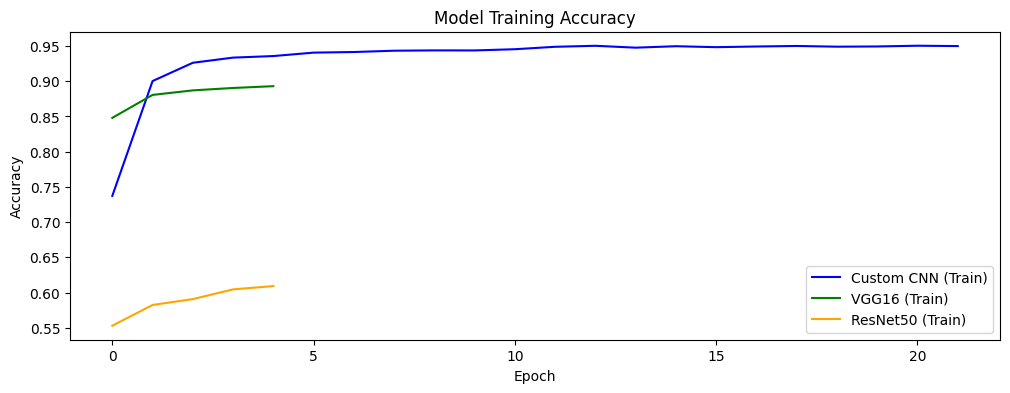

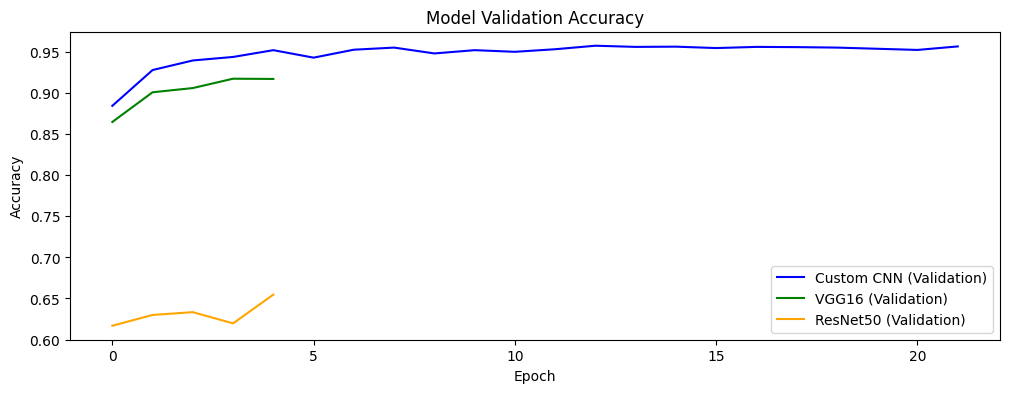

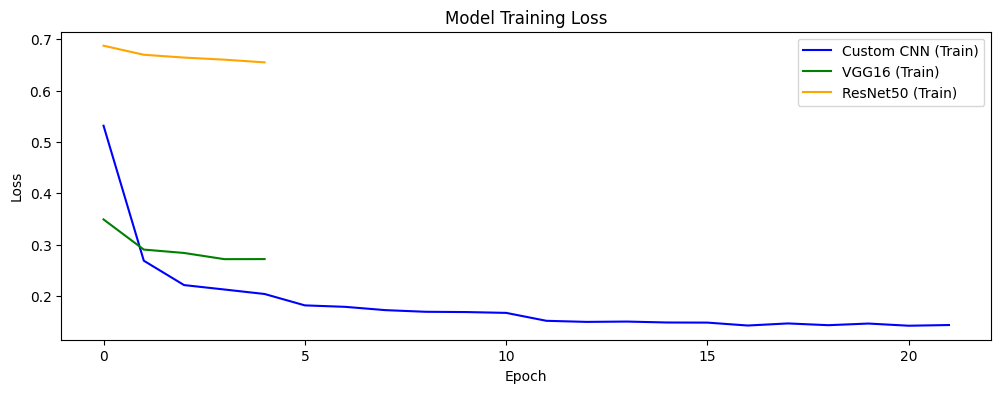

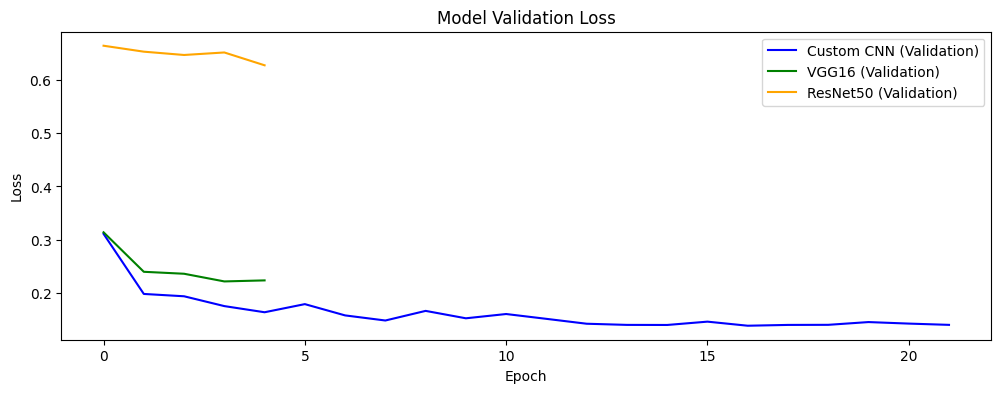

In [68]:


custom_cnn_color = 'blue'
vgg16_color = 'green'
resnet50_color = 'orange'

plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Custom CNN (Train)', color=custom_cnn_color)
plt.plot(history_vgg.history['accuracy'], label='VGG16 (Train)', color=vgg16_color)

if 'history_resnet' in locals():
    plt.plot(history_resnet.history['accuracy'], label='ResNet50 (Train)', color=resnet50_color)

plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history.history['val_accuracy'], label='Custom CNN (Validation)', color=custom_cnn_color)
plt.plot(history_vgg.history['val_accuracy'], label='VGG16 (Validation)', color=vgg16_color)

if 'history_resnet' in locals():
    plt.plot(history_resnet.history['val_accuracy'], label='ResNet50 (Validation)', color=resnet50_color)

plt.title('Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Custom CNN (Train)', color=custom_cnn_color)
plt.plot(history_vgg.history['loss'], label='VGG16 (Train)', color=vgg16_color)

if 'history_resnet' in locals():
    plt.plot(history_resnet.history['loss'], label='ResNet50 (Train)', color=resnet50_color)

plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history.history['val_loss'], label='Custom CNN (Validation)', color=custom_cnn_color)
plt.plot(history_vgg.history['val_loss'], label='VGG16 (Validation)', color=vgg16_color)

if 'history_resnet' in locals():
    plt.plot(history_resnet.history['val_loss'], label='ResNet50 (Validation)', color=resnet50_color)

plt.title('Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
